<h1> Stage2 - multiple energies </h1>

Let's move on to a new MC dataset where the photons don't always have energies of $E=140$ GeV but every energy up until 200 GeV. This notebook will describe the starting point of the network in stage 2 which was developed in stage 1. 

In [11]:
import myfunctions as mf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time

In [22]:
tf.debugging.set_log_device_placement(True)

In [2]:
# load data
rootfile = uproot.open("./stage2_clusters.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
clustersNxN, coord, ind_del = mf.form_cluster(xMC, yMC, EMC)

Clusters are bigger than 5 celles:  4 6
Clusters are bigger than 5 celles:  5 6
Clusters are bigger than 5 celles:  5 6
Clusters are bigger than 5 celles:  6 4
Clusters are bigger than 5 celles:  4 6
Clusters are bigger than 5 celles:  5 6
Clusters are bigger than 5 celles:  6 4
Clusters are bigger than 5 celles:  5 6
Clusters are bigger than 5 celles:  4 6
Clusters are bigger than 5 celles:  6 4
Clusters are bigger than 5 celles:  6 4
Clusters are bigger than 5 celles:  6 4
Clusters are bigger than 5 celles:  4 7
Clusters are bigger than 5 celles:  6 5
Clusters are bigger than 5 celles:  4 6
Clusters are bigger than 5 celles:  5 6
Clusters are bigger than 5 celles:  6 4
Clusters are bigger than 5 celles:  4 6
Clusters are bigger than 5 celles:  6 4
Clusters are bigger than 5 celles:  4 6
Clusters are bigger than 5 celles:  6 4
Clusters are bigger than 5 celles:  6 5
Clusters are bigger than 5 celles:  6 5
Clusters are bigger than 5 celles:  6 5
Clusters are bigger than 5 celles:  6 4


In [5]:
print("Useable clusters: ", len(clustersNxN))
print("Deleted clusters: ", len(ind_del))

Useable clusters:  753956
Deleted clusters:  54


As 50 compared to 0.7 M is rather small, I'll still use 5x5 clusters.

In [7]:
clusters = clustersNxN.reshape((clustersNxN.shape[0], 25))
# cut data and from trainings and test data
xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri, clusters_t, clusters_v, coord_t, coord_v = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit, ind_del, clusters, coord)
# prep data
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord_t)
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

<h2> The network </h2>

This will be the basic network for stage 2:

In [8]:
model1 = keras.Sequential([layers.Input(shape=(25)),
                         layers.LayerNormalization(axis=1),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model1.summary()
model1.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.00001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 25)                50        
_________________________________________________________________
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2

Check if GPU is running...

In [23]:
tf.debugging.set_log_device_placement(True)
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [24]:
a = time.time()
fit_hist = model1.fit(clusters_t, training, batch_size=50, epochs=200, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/200
10857/10857 [==============================] - 12s 1ms/step - loss: 911.3542 - val_loss: 899.7076
Epoch 2/200
10857/10857 [==============================] - 12s 1ms/step - loss: 892.2061 - val_loss: 880.0043
Epoch 3/200
10857/10857 [==============================] - 12s 1ms/step - loss: 869.6287 - val_loss: 856.8755
Epoch 4/200
10857/10857 [==============================] - 12s 1ms/step - loss: 847.3121 - val_loss: 837.0477
Epoch 5/200
10857/10857 [==============================] - 12s 1ms/step - loss: 826.2861 - val_loss: 815.1346
Epoch 6/200
10857/10857 [==============================] - 12s 1ms/step - loss: 800.9792 - val_loss: 783.8734
Epoch 7/200
10857/10857 [==============================] - 12s 1ms/step - loss: 763.6121 - val_loss: 737.0895
Epoch 8/200
10857/10857 [==============================] - 12s 1ms/step - loss: 705.7847 - val_loss: 669.9039
Epoch 9/200
10857/10857 [==============================] - 12s 1ms/step - loss: 627.3297 - val_loss: 584.5095
Epoch 10/2

Epoch 75/200
10857/10857 [==============================] - 12s 1ms/step - loss: 185.5021 - val_loss: 185.8772
Epoch 76/200
10857/10857 [==============================] - 12s 1ms/step - loss: 184.9592 - val_loss: 186.6108
Epoch 77/200
10857/10857 [==============================] - 12s 1ms/step - loss: 183.9220 - val_loss: 182.8544
Epoch 78/200
10857/10857 [==============================] - 12s 1ms/step - loss: 183.3996 - val_loss: 179.9792
Epoch 79/200
10857/10857 [==============================] - 12s 1ms/step - loss: 182.3364 - val_loss: 183.7433
Epoch 80/200
10857/10857 [==============================] - 12s 1ms/step - loss: 182.3314 - val_loss: 182.5786
Epoch 81/200
10857/10857 [==============================] - 12s 1ms/step - loss: 181.4326 - val_loss: 177.7124
Epoch 82/200
10857/10857 [==============================] - 12s 1ms/step - loss: 180.7942 - val_loss: 179.5360
Epoch 83/200
10857/10857 [==============================] - 12s 1ms/step - loss: 180.2639 - val_loss: 176.4726
E

10857/10857 [==============================] - 12s 1ms/step - loss: 159.0387 - val_loss: 159.1230
Epoch 149/200
10857/10857 [==============================] - 12s 1ms/step - loss: 159.0061 - val_loss: 161.9196
Epoch 150/200
10857/10857 [==============================] - 12s 1ms/step - loss: 158.8928 - val_loss: 155.5046
Epoch 151/200
10857/10857 [==============================] - 12s 1ms/step - loss: 158.5063 - val_loss: 157.1192
Epoch 152/200
10857/10857 [==============================] - 12s 1ms/step - loss: 158.4616 - val_loss: 161.9815
Epoch 153/200
10857/10857 [==============================] - 12s 1ms/step - loss: 158.0662 - val_loss: 158.1530
Epoch 154/200
10857/10857 [==============================] - 12s 1ms/step - loss: 158.0946 - val_loss: 159.8435
Epoch 155/200
10857/10857 [==============================] - 12s 1ms/step - loss: 157.7597 - val_loss: 155.7527
Epoch 156/200
10857/10857 [==============================] - 12s 1ms/step - loss: 157.3661 - val_loss: 154.7878
Epoch 

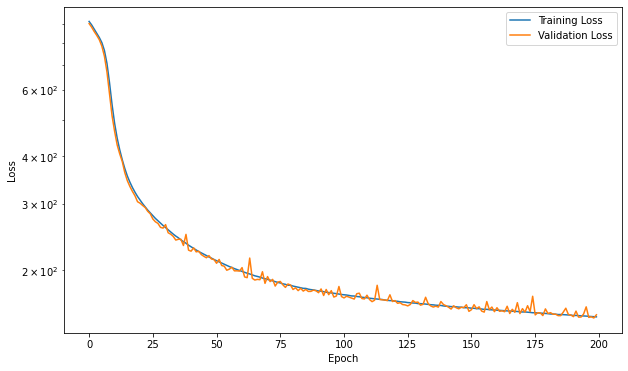

In [25]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [26]:
output = model1.predict(clusters_v)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

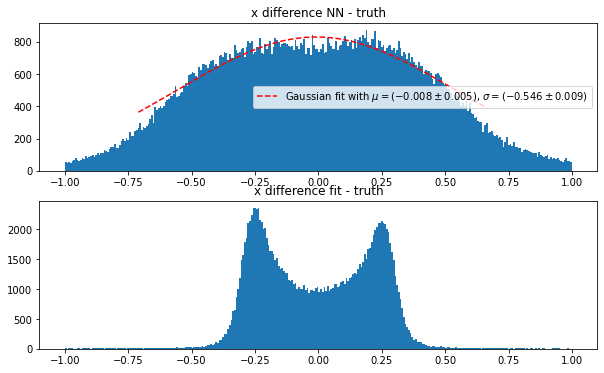

In [28]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x")

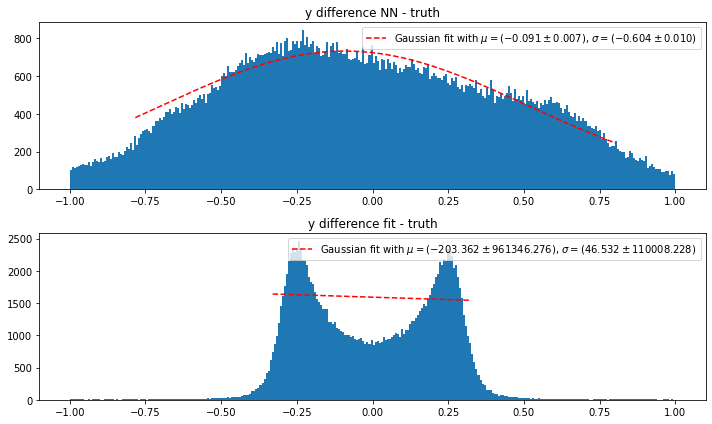

(array([-9.13617221e-02, -6.03602223e-01,  1.10903764e+03]),
 array([6.58928193e-03, 9.77143331e-03, 1.43867947e+01]),
 array([-2.03362422e+02,  4.65324619e+01,  2.60668143e+09]),
 array([9.61346276e+05, 1.10008228e+05, 1.23371768e+14]))

In [29]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

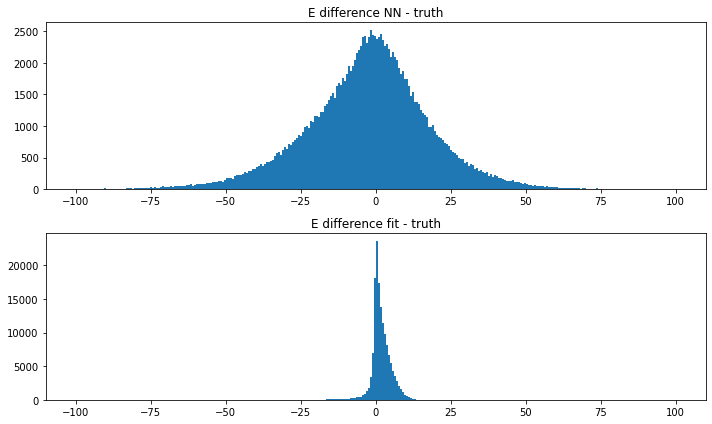

In [31]:
mf.histo_output(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-100,100), fit=False)

The results are not satisfying. If one looks at the loss function one can see that the minimum is still not reached. I'll train on more epochs.

In [34]:
a = time.time()
fit_hist = model1.fit(clusters_t, training, batch_size=50, epochs=200, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/200
10857/10857 [==============================] - 12s 1ms/step - loss: 147.4515 - val_loss: 145.3233
Epoch 2/200
10857/10857 [==============================] - 12s 1ms/step - loss: 147.1448 - val_loss: 145.3156
Epoch 3/200
10857/10857 [==============================] - 12s 1ms/step - loss: 147.1511 - val_loss: 145.1129
Epoch 4/200
10857/10857 [==============================] - 12s 1ms/step - loss: 146.7281 - val_loss: 145.7993
Epoch 5/200
10857/10857 [==============================] - 12s 1ms/step - loss: 146.6219 - val_loss: 146.2809
Epoch 6/200
10857/10857 [==============================] - 12s 1ms/step - loss: 146.6953 - val_loss: 144.8836
Epoch 7/200
10857/10857 [==============================] - 12s 1ms/step - loss: 146.6050 - val_loss: 145.4933
Epoch 8/200
10857/10857 [==============================] - 12s 1ms/step - loss: 146.5539 - val_loss: 145.2709
Epoch 9/200
10857/10857 [==============================] - 12s 1ms/step - loss: 146.4901 - val_loss: 148.1642
Epoch 10/2

Epoch 75/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.9625 - val_loss: 143.2802
Epoch 76/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.8636 - val_loss: 140.3798
Epoch 77/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.8541 - val_loss: 141.8238
Epoch 78/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.7339 - val_loss: 139.0927
Epoch 79/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.6474 - val_loss: 141.6267
Epoch 80/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.5778 - val_loss: 140.7599
Epoch 81/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.5747 - val_loss: 144.1458
Epoch 82/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.2781 - val_loss: 138.1662
Epoch 83/200
10857/10857 [==============================] - 12s 1ms/step - loss: 139.1774 - val_loss: 139.6139
E

10857/10857 [==============================] - 12s 1ms/step - loss: 134.3811 - val_loss: 135.0511
Epoch 149/200
10857/10857 [==============================] - 12s 1ms/step - loss: 134.2911 - val_loss: 134.2879
Epoch 150/200
10857/10857 [==============================] - 12s 1ms/step - loss: 134.2784 - val_loss: 135.9959
Epoch 151/200
10857/10857 [==============================] - 12s 1ms/step - loss: 134.3759 - val_loss: 134.8252
Epoch 152/200
10857/10857 [==============================] - 12s 1ms/step - loss: 134.1019 - val_loss: 135.5844
Epoch 153/200
10857/10857 [==============================] - 12s 1ms/step - loss: 134.1660 - val_loss: 134.5929
Epoch 154/200
10857/10857 [==============================] - 12s 1ms/step - loss: 133.9977 - val_loss: 135.7169
Epoch 155/200
10857/10857 [==============================] - 12s 1ms/step - loss: 133.9188 - val_loss: 138.9854
Epoch 156/200
10857/10857 [==============================] - 12s 1ms/step - loss: 133.9774 - val_loss: 145.4286
Epoch 

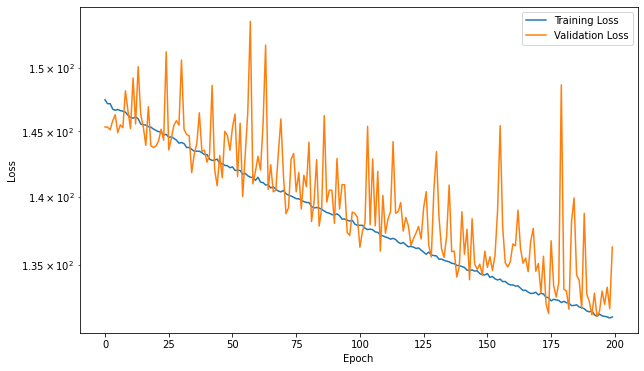

In [42]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [35]:
keras.models.save_model(model1, 'stage2model_400epochs')

INFO:tensorflow:Assets written to: stage2model_400epochs/assets


Ideas to improve the network: 

- make the achistructure more complex (more layers etc.)
- normalize the output. Set 200 GeV = 1, 0 Gev = 0 to make weights and biases smaller. 


In [38]:
output1 = model1.predict(clusters_v)

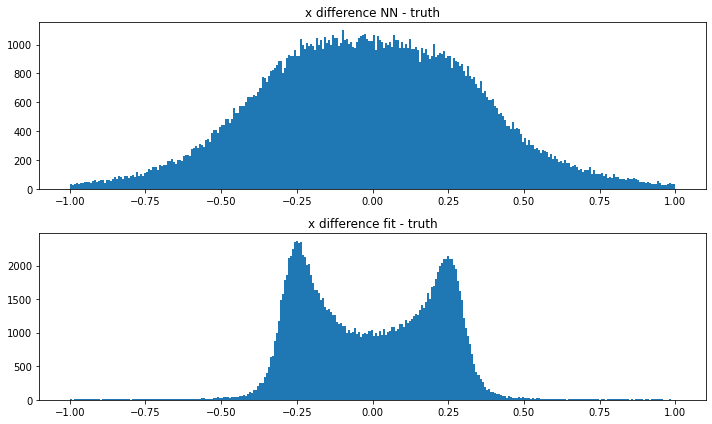

In [39]:
mf.histo_output(output1.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", fit=False)

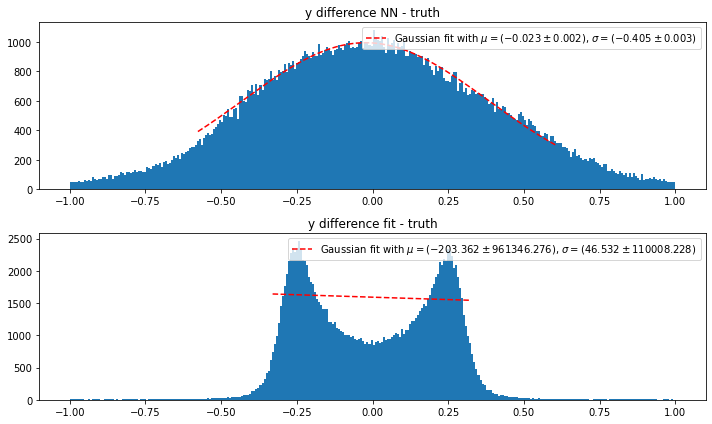

(array([-2.29550404e-02, -4.05392480e-01,  1.01110761e+03]),
 array([2.38935151e-03, 3.36786558e-03, 6.70377507e+00]),
 array([-2.03362422e+02,  4.65324619e+01,  2.60668143e+09]),
 array([9.61346276e+05, 1.10008228e+05, 1.23371768e+14]))

In [40]:
mf.histo_output(output1.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

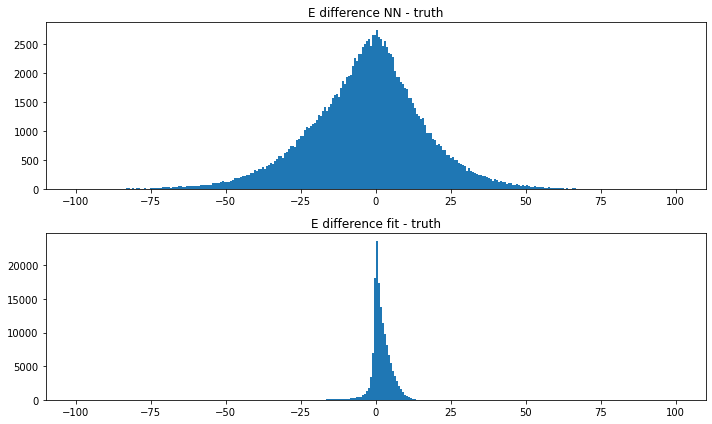

In [41]:
mf.histo_output(output1.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-100,100), fit=False)

train even more....

In [43]:
a = time.time()
fit_hist_600= model1.fit(clusters_t, training, batch_size=50, epochs=600, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/600
10857/10857 [==============================] - 12s 1ms/step - loss: 131.0692 - val_loss: 133.1814
Epoch 2/600
10857/10857 [==============================] - 12s 1ms/step - loss: 131.0981 - val_loss: 134.7507
Epoch 3/600
10857/10857 [==============================] - 12s 1ms/step - loss: 131.0080 - val_loss: 132.8824
Epoch 4/600
10857/10857 [==============================] - 12s 1ms/step - loss: 130.9126 - val_loss: 130.3931
Epoch 5/600
10857/10857 [==============================] - 12s 1ms/step - loss: 130.8998 - val_loss: 134.5232
Epoch 6/600
10857/10857 [==============================] - 12s 1ms/step - loss: 130.7146 - val_loss: 134.8453
Epoch 7/600
10857/10857 [==============================] - 12s 1ms/step - loss: 130.7061 - val_loss: 130.1590
Epoch 8/600
10857/10857 [==============================] - 12s 1ms/step - loss: 130.6013 - val_loss: 132.3229
Epoch 9/600
10857/10857 [==============================] - 12s 1ms/step - loss: 130.7120 - val_loss: 132.7492
Epoch 10/6

Epoch 75/600
10857/10857 [==============================] - 12s 1ms/step - loss: 127.2055 - val_loss: 127.1967
Epoch 76/600
10857/10857 [==============================] - 12s 1ms/step - loss: 127.2007 - val_loss: 128.3133
Epoch 77/600
10857/10857 [==============================] - 12s 1ms/step - loss: 127.0729 - val_loss: 128.4034
Epoch 78/600
10857/10857 [==============================] - 12s 1ms/step - loss: 126.8659 - val_loss: 127.1983
Epoch 79/600
10857/10857 [==============================] - 12s 1ms/step - loss: 126.9754 - val_loss: 130.3223
Epoch 80/600
10857/10857 [==============================] - 12s 1ms/step - loss: 127.0062 - val_loss: 126.7987
Epoch 81/600
10857/10857 [==============================] - 12s 1ms/step - loss: 126.8456 - val_loss: 128.9789
Epoch 82/600
10857/10857 [==============================] - 12s 1ms/step - loss: 126.7295 - val_loss: 131.9104
Epoch 83/600
10857/10857 [==============================] - 12s 1ms/step - loss: 126.7938 - val_loss: 126.9751
E

10857/10857 [==============================] - 12s 1ms/step - loss: 123.7849 - val_loss: 124.7904
Epoch 149/600
10857/10857 [==============================] - 12s 1ms/step - loss: 123.6638 - val_loss: 125.6785
Epoch 150/600
10857/10857 [==============================] - 12s 1ms/step - loss: 123.5302 - val_loss: 124.0246
Epoch 151/600
10857/10857 [==============================] - 12s 1ms/step - loss: 123.5252 - val_loss: 127.6586
Epoch 152/600
10857/10857 [==============================] - 12s 1ms/step - loss: 123.5889 - val_loss: 124.2779
Epoch 153/600
10857/10857 [==============================] - 12s 1ms/step - loss: 123.3112 - val_loss: 124.9587
Epoch 154/600
10857/10857 [==============================] - 12s 1ms/step - loss: 123.5077 - val_loss: 125.0957
Epoch 155/600
10857/10857 [==============================] - 12s 1ms/step - loss: 123.3202 - val_loss: 124.6593
Epoch 156/600
10857/10857 [==============================] - 12s 1ms/step - loss: 123.2932 - val_loss: 124.2190
Epoch 

10857/10857 [==============================] - 12s 1ms/step - loss: 120.6155 - val_loss: 122.8001
Epoch 222/600
10857/10857 [==============================] - 12s 1ms/step - loss: 120.5043 - val_loss: 122.6594
Epoch 223/600
10857/10857 [==============================] - 12s 1ms/step - loss: 120.5144 - val_loss: 122.7006
Epoch 224/600
10857/10857 [==============================] - 12s 1ms/step - loss: 120.5140 - val_loss: 123.5908
Epoch 225/600
10857/10857 [==============================] - 12s 1ms/step - loss: 120.5033 - val_loss: 122.9018
Epoch 226/600
10857/10857 [==============================] - 12s 1ms/step - loss: 120.3451 - val_loss: 123.5338
Epoch 227/600
10857/10857 [==============================] - 12s 1ms/step - loss: 120.3524 - val_loss: 126.2791
Epoch 228/600
10857/10857 [==============================] - 12s 1ms/step - loss: 120.3336 - val_loss: 122.6278
Epoch 229/600
10857/10857 [==============================] - 12s 1ms/step - loss: 120.2928 - val_loss: 122.4844
Epoch 

10857/10857 [==============================] - 12s 1ms/step - loss: 117.9003 - val_loss: 124.3604
Epoch 295/600
10857/10857 [==============================] - 12s 1ms/step - loss: 117.8378 - val_loss: 119.6562
Epoch 296/600
10857/10857 [==============================] - 12s 1ms/step - loss: 117.7158 - val_loss: 119.2962
Epoch 297/600
10857/10857 [==============================] - 12s 1ms/step - loss: 117.6291 - val_loss: 118.5178
Epoch 298/600
10857/10857 [==============================] - 12s 1ms/step - loss: 117.5408 - val_loss: 122.5837
Epoch 299/600
10857/10857 [==============================] - 12s 1ms/step - loss: 117.5879 - val_loss: 121.3248
Epoch 300/600
10857/10857 [==============================] - 12s 1ms/step - loss: 117.5143 - val_loss: 119.0759
Epoch 301/600
10857/10857 [==============================] - 12s 1ms/step - loss: 117.5429 - val_loss: 120.8688
Epoch 302/600
10857/10857 [==============================] - 12s 1ms/step - loss: 117.5567 - val_loss: 119.9626
Epoch 

10857/10857 [==============================] - 12s 1ms/step - loss: 115.2781 - val_loss: 119.7185
Epoch 368/600
10857/10857 [==============================] - 12s 1ms/step - loss: 115.2098 - val_loss: 118.6408
Epoch 369/600
10857/10857 [==============================] - 12s 1ms/step - loss: 115.1042 - val_loss: 118.6115
Epoch 370/600
10857/10857 [==============================] - 12s 1ms/step - loss: 115.1409 - val_loss: 120.5376
Epoch 371/600
10857/10857 [==============================] - 12s 1ms/step - loss: 115.0416 - val_loss: 116.8255
Epoch 372/600
10857/10857 [==============================] - 12s 1ms/step - loss: 115.1275 - val_loss: 116.8839
Epoch 373/600
10857/10857 [==============================] - 12s 1ms/step - loss: 114.9709 - val_loss: 118.1106
Epoch 374/600
10857/10857 [==============================] - 12s 1ms/step - loss: 115.0394 - val_loss: 114.9737
Epoch 375/600
10857/10857 [==============================] - 12s 1ms/step - loss: 114.9978 - val_loss: 115.7545
Epoch 

10857/10857 [==============================] - 12s 1ms/step - loss: 112.7867 - val_loss: 115.5585
Epoch 441/600
10857/10857 [==============================] - 12s 1ms/step - loss: 112.6859 - val_loss: 114.6867
Epoch 442/600
10857/10857 [==============================] - 12s 1ms/step - loss: 112.6938 - val_loss: 113.8092
Epoch 443/600
10857/10857 [==============================] - 12s 1ms/step - loss: 112.6010 - val_loss: 116.3139
Epoch 444/600
10857/10857 [==============================] - 12s 1ms/step - loss: 112.6621 - val_loss: 113.9822
Epoch 445/600
10857/10857 [==============================] - 12s 1ms/step - loss: 112.5686 - val_loss: 114.9431
Epoch 446/600
10857/10857 [==============================] - 12s 1ms/step - loss: 112.6398 - val_loss: 114.6707
Epoch 447/600
10857/10857 [==============================] - 12s 1ms/step - loss: 112.5549 - val_loss: 115.4677
Epoch 448/600
10857/10857 [==============================] - 12s 1ms/step - loss: 112.4865 - val_loss: 117.6166
Epoch 

10857/10857 [==============================] - 12s 1ms/step - loss: 110.4145 - val_loss: 112.1876
Epoch 514/600
10857/10857 [==============================] - 12s 1ms/step - loss: 110.4546 - val_loss: 111.4210
Epoch 515/600
10857/10857 [==============================] - 12s 1ms/step - loss: 110.4138 - val_loss: 111.0039
Epoch 516/600
10857/10857 [==============================] - 12s 1ms/step - loss: 110.4174 - val_loss: 111.8686
Epoch 517/600
10857/10857 [==============================] - 12s 1ms/step - loss: 110.3402 - val_loss: 113.8974
Epoch 518/600
10857/10857 [==============================] - 12s 1ms/step - loss: 110.3170 - val_loss: 111.1689
Epoch 519/600
10857/10857 [==============================] - 12s 1ms/step - loss: 110.2399 - val_loss: 112.4903
Epoch 520/600
10857/10857 [==============================] - 12s 1ms/step - loss: 110.1405 - val_loss: 111.8295
Epoch 521/600
10857/10857 [==============================] - 12s 1ms/step - loss: 110.2013 - val_loss: 113.1849
Epoch 

10857/10857 [==============================] - 12s 1ms/step - loss: 108.2037 - val_loss: 115.3359
Epoch 587/600
10857/10857 [==============================] - 12s 1ms/step - loss: 108.3191 - val_loss: 114.1884
Epoch 588/600
10857/10857 [==============================] - 12s 1ms/step - loss: 108.2238 - val_loss: 109.7841
Epoch 589/600
10857/10857 [==============================] - 12s 1ms/step - loss: 108.1855 - val_loss: 110.2310
Epoch 590/600
10857/10857 [==============================] - 12s 1ms/step - loss: 108.2651 - val_loss: 109.7635
Epoch 591/600
10857/10857 [==============================] - 12s 1ms/step - loss: 108.0798 - val_loss: 111.8661
Epoch 592/600
10857/10857 [==============================] - 12s 1ms/step - loss: 107.9737 - val_loss: 109.1419
Epoch 593/600
10857/10857 [==============================] - 12s 1ms/step - loss: 108.0629 - val_loss: 113.0495
Epoch 594/600
10857/10857 [==============================] - 12s 1ms/step - loss: 108.0817 - val_loss: 109.9885
Epoch 

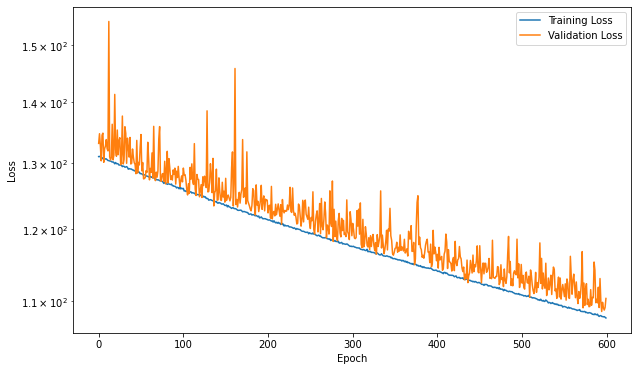

In [44]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist_600)

In [49]:
output2 = model1.predict(clusters_v)

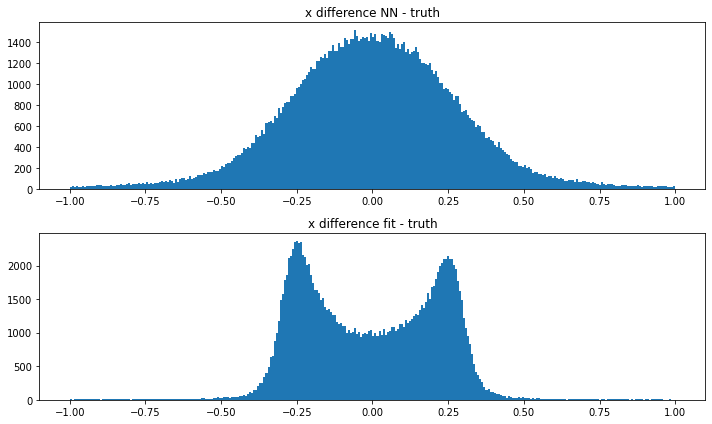

In [50]:
mf.histo_output(output2.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", fit=False)

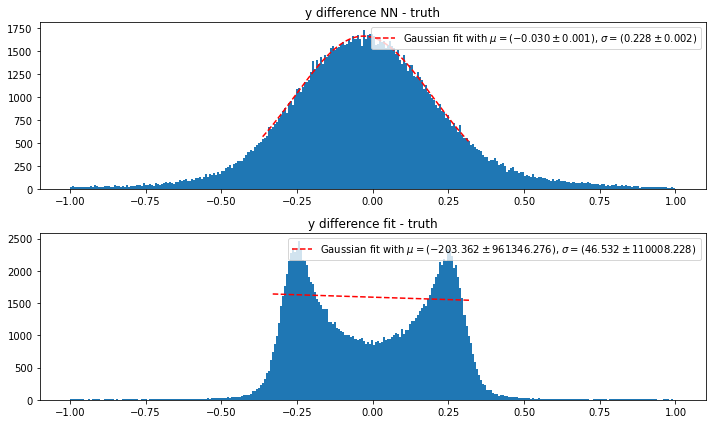

(array([-3.03471102e-02,  2.27575031e-01,  9.48429980e+02]),
 array([1.15380515e-03, 1.60424727e-03, 5.33356032e+00]),
 array([-2.03362422e+02,  4.65324619e+01,  2.60668143e+09]),
 array([9.61346276e+05, 1.10008228e+05, 1.23371768e+14]))

In [51]:
mf.histo_output(output2.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

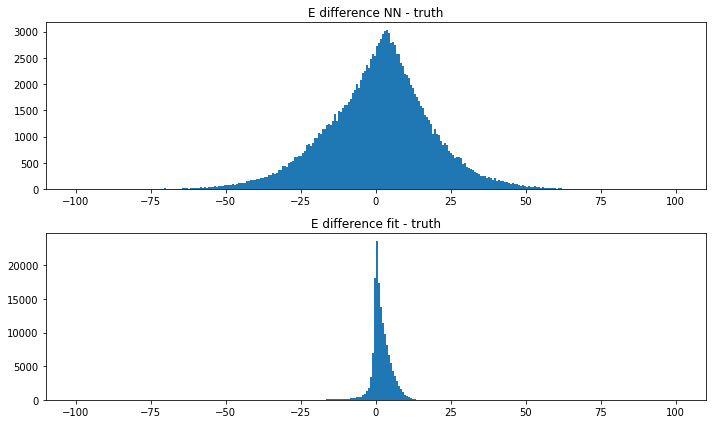

In [52]:
mf.histo_output(output2.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-100,100), fit=False)

In [48]:
keras.models.save_model(model1, 'stage2model_1000epochs')

INFO:tensorflow:Assets written to: stage2model_1000epochs/assets
